## Recurrent Neural Networks

In [1]:
import os
os.environ["PYTHONHASHSEED"] = "0"

import random as rn
rn.seed(1254)

import numpy as np
np.random.seed(1515)

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import librosa, librosa.display, IPython.display as ipd
from tqdm import tqdm
import glob
import pandas as pd
import h5py
from sklearn import preprocessing
import pickle

In [ ]:
plt.rcParams['figure.figsize'] = (14, 6)

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import tensorflow as tf
tf.set_random_seed(2)

config = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1 
)

config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
sess = tf.Session(graph= tf.get_default_graph(), config=config) 
    
import keras 
from keras import backend as K
K.set_session(sess)  # set this TensorFlow session as the default session for Keras

from keras.layers import Input, Conv2D, MaxPooling2D, LSTM, GRU, Bidirectional
from keras.layers import Dense, Flatten
from keras.layers.core import Dropout
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [3]:
#SET PATHS
dataspace = '/vol/vssp/datasets/audio01/UrbanSound8K/audio/'
projectspace = '/vol/vssp/AcousticEventsDetection/DLGdansk/UrbanSound/'

metadatafile = '/vol/vssp/datasets/audio01/UrbanSound8K/metadata/UrbanSound8K.csv'
metadata = pd.read_csv(metadatafile)

hdf5_path = os.path.join(projectspace,'dataset.hdf5') 
modelfolder = os.path.join(projectspace,'models')
scalerpath = os.path.join(projectspace,'scaler.pkl')

In [4]:
# LOAD DATA
hf = h5py.File(hdf5_path, 'r')
X_train = np.array(hf.get('X_train') )
y_train = np.array(hf.get('y_train'))
X_val =  np.array(hf.get('X_val'))
y_val= np.array(hf.get('y_val'))
X_test = np.array(hf.get('X_test'))
y_test = np.array(hf.get('y_test'))

n_features= hf.get('n_features').value
n_frames=hf.get('max_length_samp').value
label_list= hf.get('label_list').value

In [5]:
# SCALE THE DATA
scaler=pickle.load(open(scalerpath, 'rb'))

X_train_scaled = [scaler.transform(x.T) for x in X_train]
X_val_scaled = [scaler.transform(x.T) for x in X_val]
X_test_scaled = [scaler.transform(x.T) for x in X_test]


In [7]:
def build_rnn(n_frames=n_frames, n_features=n_features,
                     n_classes=10):

    # INPUT
    x = Input(shape=(n_frames, n_features), dtype='float32')
  
    y= LSTM(120, return_sequences = True)(x)
    y= Dropout(0.2)(y)  
    
    y= LSTM(120)(y)
    y= Dropout(0.2)(y) 

    y = Dense(n_classes, activation='sigmoid')(y)

    m = Model(inputs=x, outputs=y)
    return m

In [8]:
m = build_rnn(n_features=40,)
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 173, 40)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 173, 120)          77280     
_________________________________________________________________
dropout_1 (Dropout)          (None, 173, 120)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 120)               115680    
_________________________________________________________________
dropout_2 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1210      
Total params: 194,170
Trainable params: 194,170
Non-trainable params: 0
_________________________________________________________________


In [9]:
m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
model_checkpoint = ModelCheckpoint(
    os.path.join(modelfolder, 'rnn_epoch_{epoch:03d}_val_loss_{val_loss:.4f}.hdf5'),
    monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1)
callbacks = [early_stopping, model_checkpoint]

history = m.fit(x=np.array(X_train_scaled), y=y_train, batch_size=130,
                    epochs=200, verbose=True,
                    validation_data=(np.array(X_val_scaled), y_val), shuffle=True)

Train on 7079 samples, validate on 816 samples
Epoch 1/200
7079/7079 [==============================] - 41s 6ms/step - loss: 1.8744 - acc: 0.3145 - val_loss: 1.7283 - val_acc: 0.3039
Epoch 2/200
7079/7079 [==============================] - 40s 6ms/step - loss: 1.5935 - acc: 0.4015 - val_loss: 1.6581 - val_acc: 0.3431
Epoch 3/200
7079/7079 [==============================] - 41s 6ms/step - loss: 1.4989 - acc: 0.4310 - val_loss: 1.6393 - val_acc: 0.3395
Epoch 4/200
7079/7079 [==============================] - 39s 6ms/step - loss: 1.4520 - acc: 0.4670 - val_loss: 1.6569 - val_acc: 0.3517
Epoch 5/200
7079/7079 [==============================] - 39s 6ms/step - loss: 1.4328 - acc: 0.4618 - val_loss: 1.6606 - val_acc: 0.3382
Epoch 6/200
7079/7079 [==============================] - 41s 6ms/step - loss: 1.4758 - acc: 0.4492 - val_loss: 1.5822 - val_acc: 0.3578
Epoch 7/200
7079/7079 [==============================] - 41s 6ms/step - loss: 1.3887 - acc: 0.4707 - val_loss: 1.5697 - val_acc: 0.3554
E

7079/7079 [==============================] - 39s 6ms/step - loss: 0.5044 - acc: 0.8387 - val_loss: 1.6533 - val_acc: 0.5625
Epoch 61/200
7079/7079 [==============================] - 40s 6ms/step - loss: 0.5707 - acc: 0.8131 - val_loss: 1.6516 - val_acc: 0.5686
Epoch 62/200
7079/7079 [==============================] - 38s 5ms/step - loss: 0.4843 - acc: 0.8464 - val_loss: 1.5707 - val_acc: 0.5944
Epoch 63/200
7079/7079 [==============================] - 40s 6ms/step - loss: 0.4254 - acc: 0.8650 - val_loss: 1.6513 - val_acc: 0.5846
Epoch 64/200
7079/7079 [==============================] - 39s 5ms/step - loss: 0.4138 - acc: 0.8715 - val_loss: 1.8254 - val_acc: 0.5576
Epoch 65/200
7079/7079 [==============================] - 40s 6ms/step - loss: 0.4273 - acc: 0.8631 - val_loss: 1.6597 - val_acc: 0.6042
Epoch 66/200
7079/7079 [==============================] - 38s 5ms/step - loss: 0.3985 - acc: 0.8741 - val_loss: 1.6560 - val_acc: 0.5956
Epoch 67/200
7079/7079 [==============================

Epoch 120/200
7079/7079 [==============================] - 38s 5ms/step - loss: 0.2222 - acc: 0.9277 - val_loss: 1.9198 - val_acc: 0.6103
Epoch 121/200
7079/7079 [==============================] - 40s 6ms/step - loss: 0.2394 - acc: 0.9244 - val_loss: 1.9154 - val_acc: 0.6066
Epoch 122/200
7079/7079 [==============================] - 39s 6ms/step - loss: 0.2004 - acc: 0.9373 - val_loss: 1.8996 - val_acc: 0.6017
Epoch 123/200
7079/7079 [==============================] - 40s 6ms/step - loss: 0.1460 - acc: 0.9556 - val_loss: 1.9681 - val_acc: 0.6115
Epoch 124/200
7079/7079 [==============================] - 38s 5ms/step - loss: 0.1293 - acc: 0.9580 - val_loss: 1.9855 - val_acc: 0.6164
Epoch 125/200
7079/7079 [==============================] - 39s 5ms/step - loss: 0.1200 - acc: 0.9609 - val_loss: 2.0167 - val_acc: 0.6054
Epoch 126/200
7079/7079 [==============================] - 36s 5ms/step - loss: 0.1091 - acc: 0.9651 - val_loss: 2.0403 - val_acc: 0.6029
Epoch 127/200
7079/7079 [=========

7079/7079 [==============================] - 40s 6ms/step - loss: 0.1921 - acc: 0.9384 - val_loss: 2.1970 - val_acc: 0.5784
Epoch 180/200
7079/7079 [==============================] - 40s 6ms/step - loss: 0.1912 - acc: 0.9421 - val_loss: 2.1265 - val_acc: 0.6054
Epoch 181/200
7079/7079 [==============================] - 40s 6ms/step - loss: 0.1039 - acc: 0.9686 - val_loss: 2.0322 - val_acc: 0.6017
Epoch 182/200
7079/7079 [==============================] - 38s 5ms/step - loss: 0.0818 - acc: 0.9754 - val_loss: 2.2478 - val_acc: 0.5980
Epoch 183/200
7079/7079 [==============================] - 41s 6ms/step - loss: 0.0519 - acc: 0.9856 - val_loss: 2.2535 - val_acc: 0.6299
Epoch 184/200
7079/7079 [==============================] - 41s 6ms/step - loss: 0.0398 - acc: 0.9897 - val_loss: 2.3485 - val_acc: 0.6238
Epoch 185/200
7079/7079 [==============================] - 39s 5ms/step - loss: 0.0292 - acc: 0.9921 - val_loss: 2.2738 - val_acc: 0.6311
Epoch 186/200
7079/7079 [=======================

In [11]:
prediction = m.predict(np.array(X_test_scaled), batch_size=130, verbose=1)
y_predict=np.array([ np.argmax(p) for p in prediction])
y_test_label = np.array([np.argmax(y) for y in y_test])

837/837 [==============================] - 1s 2ms/step


Accuracy: 0.59


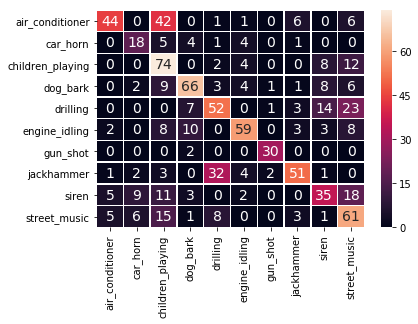

In [12]:
from sklearn.metrics import confusion_matrix

acc = np.sum(y_test_label==y_predict) / float(len(y_test_label))
print('Accuracy: {:.2f}'.format(acc))

cm = confusion_matrix(y_test_label, y_predict )
sns.heatmap(cm, annot=True, annot_kws={"size": 14}, fmt='g', linewidths=.5, yticklabels=label_list,xticklabels=label_list)